In [1]:
import discretize
from discretize import utils
import numpy as np
import scipy.sparse as sp
import sympy
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.constants import mu_0, inch, foot

from SimPEG.EM import FDEM
from SimPEG import Utils, Maps

import casingSimulations

from pymatsolver import Pardiso

%matplotlib inline

In [2]:
from SimPEG.EM import Analytics

In [3]:
simDir = 'validate_VED_analytic'

# Validate against VED

Use geometry from the [well_A example](../casing3D/WellA.ipynb) to generate a mesh suitable for capturing casing parameters. Here, the well is a bit shorter to speed up calc and get away with a slightly shorter mesh 

## Example casing model

Here we ignore all conductivity and permeability structures and only use the geometry to generate the mesh

In [4]:
# Casing parameters
casing_d = 20e-2 # first pass, lets use a 20cm casing diameter
casing_t = 1e-2 # 1cm casing thickness
casing_l = 1500 # use a well that is 1.5km long

freqs = np.r_[1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2, 0.1, 0.2, 0.5, 1.]  # 1e-6

sigma_back = 1e-1

src_a = np.r_[0., np.pi, -casing_l/2-0.5] # put the dipole in the center of the "well"
src_b = np.r_[0., np.pi, -casing_l/2+0.5]

## Whole space Model

In [5]:
# set up the casing properties
cp = casingSimulations.CasingParameters(
    sigma_back = sigma_back,
    sigma_layer = sigma_back,
    sigma_inside = sigma_back,
    sigma_casing = sigma_back, 
    sigma_air = sigma_back,
    mur_casing = 1., 
    casing_d = casing_d,
    casing_l = casing_l,
    casing_t = casing_t,
    freqs = freqs, 
    src_a = src_a,
    src_b = src_b
)

In [6]:
cp.serialize()

{u'__class__': 'CasingParameters',
 'casing_d': 0.2,
 'casing_l': 1500.0,
 'casing_t': 0.01,
 'casing_top': 0.0,
 'freqs': [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.2, 0.5, 1.0],
 'layer_z': [-1000.0, -900.0],
 'mur_casing': 1.0,
 'sigma_air': 0.1,
 'sigma_back': 0.1,
 'sigma_casing': 0.1,
 'sigma_inside': 0.1,
 'sigma_layer': 0.1,
 'src_a': [0.0, 3.141592653589793, -750.5],
 'src_b': [0.0, 3.141592653589793, -749.5],
 'version': u'0.0.1'}

In [7]:
cp.save(directory=simDir)

## Construct a mesh

In [8]:
npadx, npadz = 19, 24
dx2 = casing_l  # go out as far as the casing is deep 
csx2 = 25.
csz = 5.
pfx2 = 1.4
pfz = 1.4

ncy = 1
nstretchy = 5
stretchfact = 1.5
hy = utils.meshTensor([(1, nstretchy, -stretchfact), (1, ncy), (1, nstretchy, stretchfact)])
hy = hy * 2*np.pi/hy.sum()

cylMeshGen = casingSimulations.CasingMeshGenerator(
    cp=cp, 
    npadx=npadx, 
    npadz=npadz, 
    domain_x2=dx2, 
    hy=hy, 
    csx2=csx2, 
    csz=csz,
    pfx2=pfx2, 
    pfz=pfz
)

In [9]:
mesh = cylMeshGen.mesh

/anaconda/lib/python2.7/site-packages/matplotlib/projections/polar.py:65: RuntimeWarning: invalid value encountered in less
  mask = r < 0


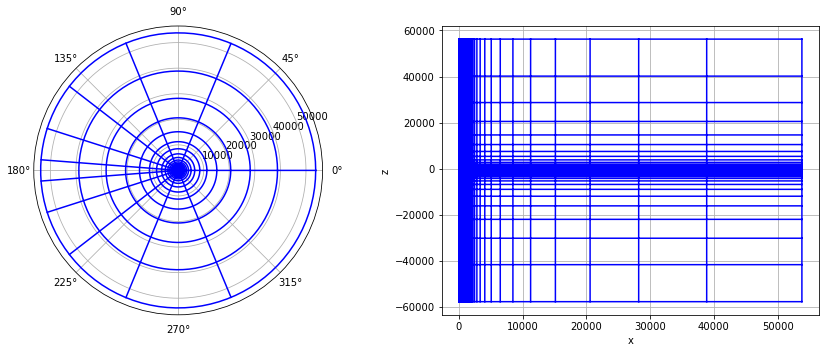

In [10]:
mesh.plotGrid()

In [11]:
print cp.skin_depth()

[ 159154.9430919    91888.14923697   50329.21210449   29057.58415663
   15915.49430919    9188.8149237     5032.92121045    3558.81271709
    2250.79079039    1591.54943092]


In [12]:
cylMeshGen.save(directory=simDir)

## Construct a source

In [13]:
src = casingSimulations.sources.VericalElectricDipole(cp=cp, mesh=mesh)

(-760.0, -730.0)

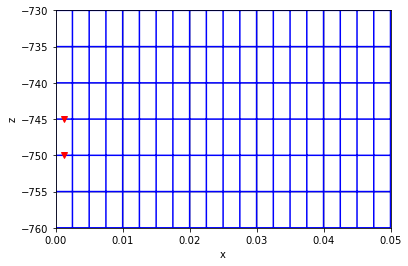

In [14]:
fig, ax = plt.subplots(1, 1)
mesh.plotGrid(ax=ax, slice='theta')
src.plot(ax=ax)

ax.set_xlim([0., 0.05])
ax.set_ylim([-760., -730.])

In [15]:
physprops = casingSimulations.PhysicalProperties(mesh, cp)

[(-2000.0, 0), (-2000.0, 0)]

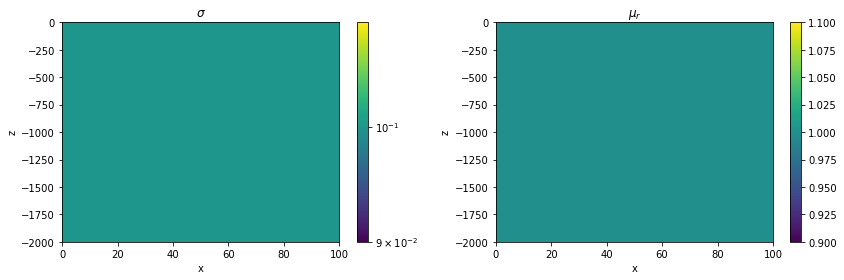

In [16]:
xlim = [0., 100.]
ylim = [-2000., 0]

ax = physprops.plot()
[a.set_xlim(xlim) for a in ax]
[a.set_ylim(ylim) for a in ax]

In [17]:
set(physprops.sigma)

{0.10000000000000001}

In [18]:
set(physprops.mur)

{1.0}

In [19]:
casingSimulations.utils.writeSimulationPy(
    directory=simDir, 
    srcType='VerticalElectricDipole',
)

wrote validate_VED_analytic/simulation.py
